In [ ]:
#!pip install folium
#!pip install geopy



In [1]:
#Import libraries
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy
from scipy import stats
from scipy.stats import boxcox
from math import sqrt
import sqlite3
import seaborn as sns
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.graphics.regressionplots import *
import statsmodels.stats.outliers_influence as st_inf
from statsmodels.stats.anova import anova_lm
import statsmodels.formula.api as smf
import missingno as msno
import folium
from folium import plugins
from folium.plugins import HeatMap
import geopy.distance
from pandasql import sqldf
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import warnings
from statsmodels.stats.outliers_influence import variance_inflation_factor

#%matplotlib qt

In [2]:
#Import data 
df = pd.read_csv('kc_house_data.csv')
df.head();

In [3]:
df.info();

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
id               21597 non-null int64
date             21597 non-null object
price            21597 non-null float64
bedrooms         21597 non-null int64
bathrooms        21597 non-null float64
sqft_living      21597 non-null int64
sqft_lot         21597 non-null int64
floors           21597 non-null float64
waterfront       19221 non-null float64
view             21534 non-null float64
condition        21597 non-null int64
grade            21597 non-null int64
sqft_above       21597 non-null int64
sqft_basement    21597 non-null object
yr_built         21597 non-null int64
yr_renovated     17755 non-null float64
zipcode          21597 non-null int64
lat              21597 non-null float64
long             21597 non-null float64
sqft_living15    21597 non-null int64
sqft_lot15       21597 non-null int64
dtypes: float64(8), int64(11), object(2)
memory usage: 3.5+ MB


In [4]:
# Column headings stripped of white spaces and made lower case for easier processing
df.columns.str.lower().str.strip();

In [5]:
df.drop('id', axis=1, inplace=True)

In [6]:
df.drop('date', axis=1, inplace=True)

In [7]:
df.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,221900.0,3,1.00,1180,5650,1.0,NaN,0.0,3,7,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650
1,538000.0,3,2.25,2570,7242,2.0,0.0,0.0,3,7,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639
2,180000.0,2,1.00,770,10000,1.0,0.0,0.0,3,6,770,0.0,1933,NaN,98028,47.7379,-122.233,2720,8062
3,604000.0,4,3.00,1960,5000,1.0,0.0,0.0,5,7,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000
4,510000.0,3,2.00,1680,8080,1.0,0.0,0.0,3,8,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503


## Question: How accurately can the general housing market in King's County, WA be predicted?
- Which factors are the main contributors in predicting price of the general housing market


Before answering the main question, what constitutes the general housing market in King's County has to be decided on and the data set will have to be tailored accordingly. 
The following questions will be addressed?
- What constitutes the general housing market? 
    - How can we differentiate luxury properties and agricultural/ industrial properties? 

<img src="king_county_housing2015.png" style="width: 900px;">

King County generally has a higher property value compared with the rest of the country and Washington State. In fact, the largest share of property value is in the $500k - $750k range. From the chart it is apparent that there are still far more houses with a value of 1 million dollars than there are with values below $200k. Therefore, properties worth a few million are not uncommon in King County and could be considered to be part of the general housing market. Properties with very low values and very high values are equally likely to be outliers for the general housing market. 

In our dataset we can consider properties with prices outside of 3 standard deviations (i.e., less than 1% in a normal distribution) to be outside of the general housing market. These properties are either high luxury or far lower than average. 

Furthermore, agricultural properties should be removed from the data as well, as the predictive features for these properties are arguably different from those for the general housing market and have not been measured in this dataset.  

<img src="farmland.png" style="width: 400px;">

While some zipcodes clearly fall within agricultural areas, generally houses and farms can be mixed for any zipcode. Therefore the ratio of the living size to the lot size may be more informative. Those cases with an a very small living to lot ratio will be excluded from the dataset on the basis that these cases are not representative of the general housing market in King County. 

The dataset will be cleaning and all missing data, placeholders and redundant measures will be dealt with before turning to issue of identifying the general housing market from our data. 

In [8]:
# Tbhe median value is comparable to online statistics about King County (https://datausa.io/profile/geo/king-county-wa/#housing).
# The website further states that "In King County, WA the largest share of households have a property value in the $500k-$750k range."
df.price.median()

450000.0

In [9]:
df.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,221900.0,3,1.00,1180,5650,1.0,NaN,0.0,3,7,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650
1,538000.0,3,2.25,2570,7242,2.0,0.0,0.0,3,7,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639
2,180000.0,2,1.00,770,10000,1.0,0.0,0.0,3,6,770,0.0,1933,NaN,98028,47.7379,-122.233,2720,8062
3,604000.0,4,3.00,1960,5000,1.0,0.0,0.0,5,7,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000
4,510000.0,3,2.00,1680,8080,1.0,0.0,0.0,3,8,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503


LOCATION DATA

In [10]:
df.lat.median()
df.long.median()

-122.23100000000001

In [11]:
df.zipcode.astype(int);
df.zipcode = df['zipcode'].astype(str);

In [12]:
zips_df = df.groupby(['zipcode']).mean()
zips_df.reset_index(level=0, inplace=True)
zips_df.price.min().round()

234284.0

In [13]:
zips_df

,zipcode,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,yr_built,yr_renovated,lat,long,sqft_living15,sqft_lot15
0,98001,2.811949e+05,3.393352,2.011773,1903.783934,14967.002770,1.430748,0.000000,0.094708,3.335180,7.296399,1723.756233,1980.867036,28.038732,47.309106,-122.270704,1830.099723,11218.875346
1,98002,2.342840e+05,3.326633,1.839196,1627.743719,7517.633166,1.334171,0.000000,0.010050,3.743719,6.693467,1522.537688,1967.773869,60.212121,47.308780,-122.213357,1479.030151,7585.482412
2,98003,2.941113e+05,3.357143,2.047321,1928.882143,10603.096429,1.310714,0.000000,0.214286,3.371429,7.542857,1663.550000,1976.885714,16.641667,47.315741,-122.310054,1876.196429,9746.178571
3,98004,1.356524e+06,3.854890,2.527603,2909.022082,13104.220820,1.432177,0.003534,0.306962,3.495268,8.687697,2419.842271,1971.470032,213.759542,47.616183,-122.205189,2674.700315,12805.022082
4,98005,8.102897e+05,3.851190,2.424107,2656.803571,19928.785714,1.279762,0.000000,0.095238,3.696429,8.488095,2160.196429,1969.744048,57.985507,47.611532,-122.167268,2567.863095,18367.773810
5,98006,8.599386e+05,3.841365,2.555723,2888.295181,13383.435743,1.459839,0.009132,0.631791,3.658635,8.795181,2300.383534,1978.720884,82.798054,47.558022,-122.146839,2785.612450,12159.959839
6,98007,6.172540e+05,3.815603,2.173759,2182.056738,10662.702128,1.411348,0.000000,0.028369,3.631206,7.964539,1885.673759,1971.070922,51.767241,47.610522,-122.142078,2124.822695,9579.900709
7,98008,6.456282e+05,3.734982,2.088339,2133.445230,10188.448763,1.181979,0.035156,0.477032,3.667845,7.653710,1713.088339,1966.325088,59.139241,47.613312,-122.115834,2021.130742,9494.996466
8,98010,4.236660e+05,3.290000,2.027500,2137.590000,55465.300000,1.480000,0.000000,0.100000,3.530000,7.400000,2000.340000,1979.180000,241.914634,47.333210,-121.999470,2008.760000,47830.270000
9,98011,4.903771e+05,3.548718,2.278205,2253.097436,11314.138462,1.502564,0.000000,0.061856,3.220513,7.774359,1954.558974,1982.148718,49.861635,47.755192,-122.201174,2248.076923,9512.087179


In [14]:
map_zips = folium.Map([47.608013, -122.335167], zoom_start=11)
map_zips;

In [15]:
# Create lists for folium markers

# pairs of latitude and longitude coordinates  
locations = zips_df[['lat', 'long']]
location_list = locations.values.tolist()
len(location_list) 

70

In [16]:
price = zips_df['zipcode'] + " $" + zips_df['price'].astype(int).astype(str)
price = price.values.tolist()
price[0:5]

['98001 $281194',
 '98002 $234284',
 '98003 $294111',
 '98004 $1356523',
 '98005 $810289']

In [17]:
folium.Marker([47.608013, -122.335167], popup= "Seattle").add_to(map_zips)
map_zips;

In [18]:
for i in range(0, len(location_list)):
    folium.Marker(location_list[i], popup=price[i]).add_to(map_zips)
map_zips;

In [19]:
coord = df[['lat', 'long']]
coordinates = coord.values.tolist()
len(coordinates)

21597

In [20]:
distances = []
for i in range(len(coordinates)):
    coords_1 = (47.625840, -122.233540) # Bellevue    #(47.608013, -122.335167) Seattle
    coords_2 = coordinates[i]
    distances.append(geopy.distance.vincenty(coords_1, coords_2).miles)

df['distance'] = pd.DataFrame(distances)
df.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,distance
0,221900.0,3,1.00,1180,5650,1.0,NaN,0.0,3,7,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650,7.995528
1,538000.0,3,2.25,2570,7242,2.0,0.0,0.0,3,7,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639,7.689150
2,180000.0,2,1.00,770,10000,1.0,0.0,0.0,3,6,770,0.0,1933,NaN,98028,47.7379,-122.233,2720,8062,7.741887
3,604000.0,4,3.00,1960,5000,1.0,0.0,0.0,5,7,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000,10.403648
4,510000.0,3,2.00,1680,8080,1.0,0.0,0.0,3,8,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503,8.828511


In [21]:
df.distance.describe()

count    21597.000000
mean        10.860158
std          6.196645
min          0.147549
25%          6.518003
50%          9.014470
75%         13.836673
max         43.284758
Name: distance, dtype: float64

In [22]:
df.price.corr(df.distance)

-0.3996844228649356

In [23]:
# drop zipcode
df.drop('zipcode', axis=1, inplace=True)

## Data Cleaning

### Placeholders and Missing Values

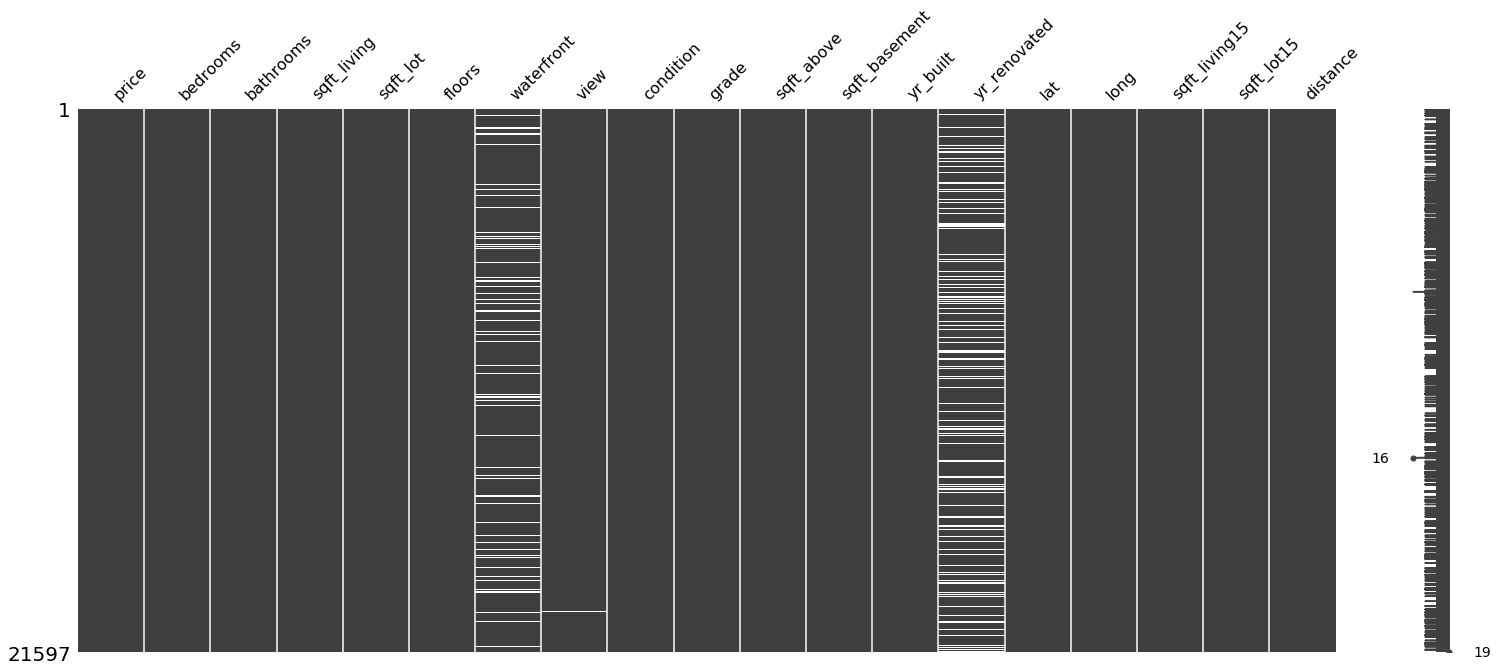

In [24]:
msno.matrix(df);

In [25]:
# The data were further investigated for disproportionate values of 0.0
def value_finder(data, value):
    placeholder_lst = []
    for col in data.columns:
        placeholder_lst.append({'Column': col, value: len(df[df[col] == value].index)})
    return placeholder_lst
value_finder(df, 0.0)

[{'Column': 'price', 0.0: 0},
 {'Column': 'bedrooms', 0.0: 0},
 {'Column': 'bathrooms', 0.0: 0},
 {'Column': 'sqft_living', 0.0: 0},
 {'Column': 'sqft_lot', 0.0: 0},
 {'Column': 'floors', 0.0: 0},
 {'Column': 'waterfront', 0.0: 19075},
 {'Column': 'view', 0.0: 19422},
 {'Column': 'condition', 0.0: 0},
 {'Column': 'grade', 0.0: 0},
 {'Column': 'sqft_above', 0.0: 0},
 {'Column': 'sqft_basement', 0.0: 0},
 {'Column': 'yr_built', 0.0: 0},
 {'Column': 'yr_renovated', 0.0: 17011},
 {'Column': 'lat', 0.0: 0},
 {'Column': 'long', 0.0: 0},
 {'Column': 'sqft_living15', 0.0: 0},
 {'Column': 'sqft_lot15', 0.0: 0},
 {'Column': 'distance', 0.0: 0}]

A number of variables had missing values, disproportionate zero values, and placeholders. Each of the follwoign variables will be dealt with in turn:
   - Sqft_basement
   - Year Renovated
   - View
   - Waterfront

##### SQFT_BASEMENT

In [26]:
# As sqrt_basement should be a numerical data type, but is a string, I had reason to believe there may be a string value present.
# The data were visually inspected and a '?' placeholder is present in the data
(df['sqft_basement'] == '?').sum()

454

In [27]:
# sqft_basement has 454 unknown values 
# First we can change the '?' placeholder to np.NaN

df['sqft_basement'].replace('?', np.NaN, inplace=True) 

In [28]:
# change the variable into a float so that we can make use of decsriptive stats to deal with the unknown values
df['sqft_basement'] = df['sqft_basement'].astype(float)
df.sqft_basement.dtype

dtype('float64')

In [29]:
# 2% of the data in sqft_basement is null. This is a small enough percentage where replacement via central measure should not impact 
# the distribution or analysis substantially
df.sqft_basement.isna().sum()/len(df.sqft_basement)*100

2.1021438162707784

In [30]:
# Inspection of sqft_basement reveals that the distribution is positively skewed. Therefore, in this case the median rather than 
# the mean can be used as a replacement value (i.e., the central measure least likely to change the shape of the distribution)
df['sqft_basement'].replace(np.NaN, 0.0, inplace=True) 

In [31]:
len(df.loc[df['sqft_basement'] == 0])

13280

In [32]:
# despite many values of zero, sqft_basement was left in the analysis due to a moderate correlation with price
print('Pearson correlation coefficent between sqft basement and price = {}'.format(round(df.sqft_basement.corr(df.price), 2)))

Pearson correlation coefficent between sqft basement and price = 0.32


C:\Users\Danyal\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


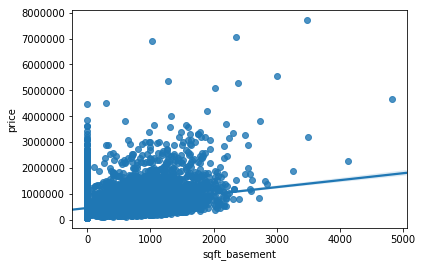

In [33]:
#df.plot.scatter(x='sqft_basement', y='price')
sns.regplot(x='sqft_basement', y='price', data =df);

In [34]:
df.sqft_basement = df.sqft_basement.astype(int)

##### YEAR RENOVATED

In [35]:
df.yr_renovated.isna().sum()

3842

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001B0DCB1E780>]],
      dtype=object)

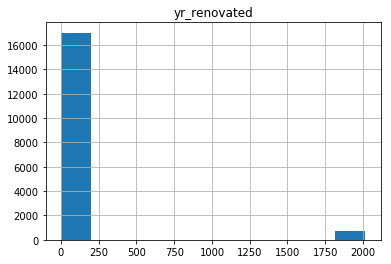

In [36]:
df.hist('yr_renovated')

In [37]:
# Further investigation of the non-zero values for this variable revealed that only 3% of data were non zero, and furthermore,
# that this 3% held a very weak correlation with the dependent variable (price). This variable was consequently deleted. 
df_temp = df.loc[df['yr_renovated'] > 0.0]
len(df_temp)/len(df)*100

3.4449229059591606

[[<matplotlib.axes._subplots.AxesSubplot object at 0x000001B0DCB66BA8>]]


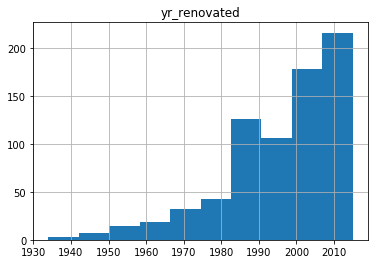

In [38]:
# histogram of 3% non zero values 
print(df_temp.hist('yr_renovated'))


In [39]:
print('Pearson correlation coefficent between price and year renovated = {}'.format(round(df_temp.price.corr(df.yr_renovated), 2)))

Pearson correlation coefficent between price and year renovated = 0.13


Due to the very small percentage of houses with the year of renovations recorded (3%) this variable will be dropped. It is clear that houses that were renovated have been given a value of 0, indicating that in addition to all of the missing data for this column, a value of 0 also indicates missing data.

In [40]:
df.drop('yr_renovated', axis=1, inplace=True)

In [41]:
df.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,lat,long,sqft_living15,sqft_lot15,distance
0,221900.0,3,1.00,1180,5650,1.0,NaN,0.0,3,7,1180,0,1955,47.5112,-122.257,1340,5650,7.995528
1,538000.0,3,2.25,2570,7242,2.0,0.0,0.0,3,7,2170,400,1951,47.7210,-122.319,1690,7639,7.689150
2,180000.0,2,1.00,770,10000,1.0,0.0,0.0,3,6,770,0,1933,47.7379,-122.233,2720,8062,7.741887
3,604000.0,4,3.00,1960,5000,1.0,0.0,0.0,5,7,1050,910,1965,47.5208,-122.393,1360,5000,10.403648
4,510000.0,3,2.00,1680,8080,1.0,0.0,0.0,3,8,1680,0,1987,47.6168,-122.045,1800,7503,8.828511


##### !!!VIEW -- investigate whether view maintains correlation after transformations

View is a measure of whether or not the property has been viewed. The value counts and scatter plot show that it is clearly interval data, with 0 being no views and the maximum number of views being 4. The vast majority of properties have not been viewed, which is resulting in an extreme possitive skew. There are also 62 missing values. Furthermore, when viewed in relation to the target variable, there appears to be no noteworthy relationship between between these variables. This is confirmed by the modest correlation between the two, which is likely being increased by the few apparent outliers. View will therefore be dropped from the data set. 

In [42]:
df.view.isna().sum()

63

In [43]:
df.view.value_counts()

0.0    19422
2.0      957
3.0      508
1.0      330
4.0      317
Name: view, dtype: int64

In [44]:
df.view.median()
df.view.replace(np.NaN, 0.0, inplace=True)
df.view.astype(int)

0        0
1        0
2        0
3        0
4        0
5        0
6        0
7        0
8        0
9        0
10       0
11       0
12       0
13       0
14       0
15       3
16       0
17       0
18       0
19       0
20       0
21       4
22       0
23       0
24       0
25       0
26       0
27       0
28       0
29       0
        ..
21567    0
21568    0
21569    0
21570    0
21571    0
21572    0
21573    0
21574    0
21575    0
21576    0
21577    2
21578    0
21579    0
21580    0
21581    0
21582    2
21583    0
21584    0
21585    0
21586    0
21587    0
21588    0
21589    0
21590    0
21591    0
21592    0
21593    0
21594    0
21595    0
21596    0
Name: view, Length: 21597, dtype: int32

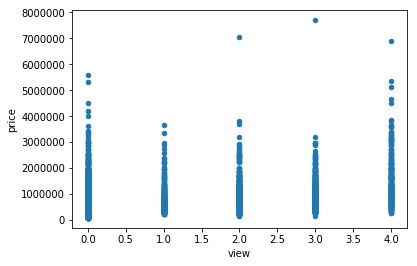

In [45]:
#temp_explore = df.dropna(subset=['view']).plot(x='view', y='price', kind='scatter')
df.plot(x='view', y='price', kind='scatter')

In [46]:
print('Pearson correlation coefficent between view and price = {}'.format(df.view.corr(df.grade)))

Pearson correlation coefficent between view and price = 0.2490823500473145


In [47]:
#df.drop('view', axis=1, inplace=True)

#### WATERFRONT -- decide whether to drop... 

In [48]:
# Waterfront indicates whether a house has a view to the waterfront. 
df.waterfront.unique()
df.waterfront.value_counts()

0.0    19075
1.0      146
Name: waterfront, dtype: int64

In [49]:
#Null values were temporarily dropped to explore further
#df.waterfront.dropna(axis=0, inplace=True);
#df.waterfront.isna().sum()

In [50]:
waterfront_ave = round(df.groupby(['waterfront']).mean(), 2)
waterfront_ave.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,view,condition,grade,sqft_above,sqft_basement,yr_built,lat,long,sqft_living15,sqft_lot15,distance
waterfront,,,,,,,,,,,,,,,,,
0.0,532641.99,3.37,2.11,2073.52,14991.12,1.49,0.20,3.41,7.65,1785.88,281.45,1971.11,47.56,-122.21,1982.05,12729.49,10.87
1.0,1717214.73,3.35,2.71,3244.75,25870.88,1.63,3.76,3.54,8.84,2508.76,728.46,1962.28,47.54,-122.28,2682.83,22893.70,10.21


In [51]:
# replace waterfront missing values with NaN category

df.waterfront = df.waterfront.astype(str)

df.waterfront.replace(np.NaN, 'NaN', inplace=True)
df.waterfront.replace(0.0, 'False', inplace=True)
df.waterfront.replace(1.0, 'True', inplace=True)

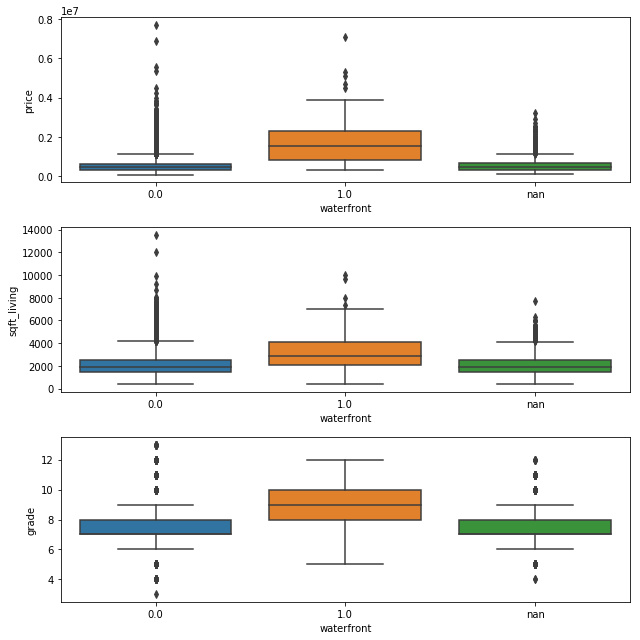

In [52]:
f, (ax1, ax2, ax3) = plt.subplots(3, figsize=(9,9))
sns.boxplot(x="waterfront", y="price", data=df, ax=ax1)
sns.boxplot(x="waterfront", y="sqft_living", data=df, ax=ax2)
sns.boxplot(x="waterfront", y="grade", data=df, ax=ax3)
f.tight_layout()

waterfront contains only a very small percentage of houses; however, there appears to be a real difference in size and price, with the waterfront = 1 median being within outlier range for price and beyond the 75th percentile for sqft_living. 
These houses are perhaps best left out of the analysis altogether, as they may represent a different population of mansions and 
wealthier properties. 

In [53]:
percentage_waterfront_view = 146/len(df.waterfront)*100
print(round(percentage_waterfront_view,2))

0.68


Houses with a waterfront view made up 0.7% of the data, but clearly had median values out of range for those properties without
a view (i.e., we could argue that they come from a significantly different population). Visual inspection indicates that the 
category of missing values is more similar to the non-view category within waterfront and will therefore be treated a such. These separation of these houses from the remaining dataset imply that they do not form part of the general housing market. Nevertheless, we will use price and not waterfront view alone as a deciding factor for luxury houses and so theyw ill be left in the dataset. However, the waterfront column will be removed as it is largely redundant. 

In [54]:
df = df[df['waterfront'] != '1.0']

In [55]:
# check that the rows were indeed dropped
df.waterfront.unique()

array(['nan', '0.0'], dtype=object)

In [56]:
# remove the waterfront column
df.drop('waterfront', axis=1, inplace=True);

In [57]:
df.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,view,condition,grade,sqft_above,sqft_basement,yr_built,lat,long,sqft_living15,sqft_lot15,distance
0,221900.0,3,1.00,1180,5650,1.0,0.0,3,7,1180,0,1955,47.5112,-122.257,1340,5650,7.995528
1,538000.0,3,2.25,2570,7242,2.0,0.0,3,7,2170,400,1951,47.7210,-122.319,1690,7639,7.689150
2,180000.0,2,1.00,770,10000,1.0,0.0,3,6,770,0,1933,47.7379,-122.233,2720,8062,7.741887
3,604000.0,4,3.00,1960,5000,1.0,0.0,5,7,1050,910,1965,47.5208,-122.393,1360,5000,10.403648
4,510000.0,3,2.00,1680,8080,1.0,0.0,3,8,1680,0,1987,47.6168,-122.045,1800,7503,8.828511


##### Final Inspection for unusual data

In [58]:
# visual inspection of data indicated no other placeholders (very unusual values). 
for col in df.columns:
    print(col)
    print(df[col].unique());

price
[221900. 538000. 180000. ... 541800. 610685. 402101.]
bedrooms
[ 3  2  4  5  1  6  7  8  9 11 10 33]
bathrooms
[1.   2.25 3.   2.   4.5  1.5  2.5  1.75 2.75 3.25 4.   3.5  0.75 4.75
 4.25 3.75 5.   1.25 0.5  5.5  5.25 6.75 6.   5.75 8.   7.5  7.75 6.25
 6.5 ]
sqft_living
[1180 2570  770 ... 3087 3118 1425]
sqft_lot
[ 5650  7242 10000 ...  5813  2388  1076]
floors
[1.  2.  1.5 3.  2.5 3.5]
view
[0. 3. 4. 2. 1.]
condition
[3 5 4 1 2]
grade
[ 7  6  8 11  9  5 10 12  4  3 13]
sqft_above
[1180 2170  770 1050 1680 3890 1715 1060 1890 1860  860 1430 1370 1810
 1980 1600 1200 1250 2330 2270 1070 2450 1710 1750 1400  790 2570 2320
 1190 1510 1090 1280  930 2360  890 2620 2600 3595 1570  920 3160  990
 2290 1640 1000 2130 2830 2250 2420 3250 1850 1590 1260 2519 1540 1110
 1770 2720 2240 3070 2380 2390  880 1040  910 3450 2350 1900 1010  960
 2660 1610  765 3520 1290 1960 1160 1210 1270 1440 2190 2920 1460 1170
 1240 3140 2030 2310  700 1080 2520 2780 1560 1450 1720 2910 1620 1360
 2070 246

In [59]:
# extreme values apparent in the descriptive statistics will be further evaluated below. 
df.describe().round()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,view,condition,grade,sqft_above,sqft_basement,yr_built,lat,long,sqft_living15,sqft_lot15,distance
count,21451.0,21451.0,21451.0,21451.0,21451.0,21451.0,21451.0,21451.0,21451.0,21451.0,21451.0,21451.0,21451.0,21451.0,21451.0,21451.0,21451.0
mean,532286.0,3.0,2.0,2072.0,15026.0,1.0,0.0,3.0,8.0,1784.0,283.0,1971.0,48.0,-122.0,1982.0,12689.0,11.0
std,342808.0,1.0,1.0,906.0,41381.0,1.0,1.0,1.0,1.0,822.0,435.0,29.0,0.0,0.0,682.0,27287.0,6.0
min,78000.0,1.0,0.0,370.0,520.0,1.0,0.0,1.0,3.0,370.0,0.0,1900.0,47.0,-123.0,399.0,651.0,0.0
25%,320000.0,3.0,2.0,1420.0,5035.0,1.0,0.0,3.0,7.0,1190.0,0.0,1952.0,47.0,-122.0,1480.0,5100.0,7.0
50%,450000.0,3.0,2.0,1910.0,7590.0,2.0,0.0,3.0,7.0,1560.0,0.0,1975.0,48.0,-122.0,1830.0,7601.0,9.0
75%,640000.0,4.0,2.0,2540.0,10578.0,2.0,0.0,4.0,8.0,2200.0,540.0,1997.0,48.0,-122.0,2356.0,10026.0,14.0
max,7700000.0,33.0,8.0,13540.0,1651359.0,4.0,4.0,5.0,13.0,9410.0,4130.0,2015.0,48.0,-121.0,6210.0,871200.0,43.0


In [60]:
# The below case likely includes a typo for rooms, as the property is very modest in terms of size. All other data for this case
# appear reasonable, so bedrooms will be replaced with the mean/ median value of 3 to retain the case. 
df.loc[df['bedrooms'] > 30]

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,view,condition,grade,sqft_above,sqft_basement,yr_built,lat,long,sqft_living15,sqft_lot15,distance
15856,640000.0,33,1.75,1620,6000,1.0,0.0,5,7,1040,580,1947,47.6878,-122.331,1330,4700,6.246428


In [61]:
df.loc[df['bedrooms'] == 33, 'bedrooms'] = 3

In [62]:
df.bedrooms.max()

11

In [63]:
df.describe().round()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,view,condition,grade,sqft_above,sqft_basement,yr_built,lat,long,sqft_living15,sqft_lot15,distance
count,21451.0,21451.0,21451.0,21451.0,21451.0,21451.0,21451.0,21451.0,21451.0,21451.0,21451.0,21451.0,21451.0,21451.0,21451.0,21451.0,21451.0
mean,532286.0,3.0,2.0,2072.0,15026.0,1.0,0.0,3.0,8.0,1784.0,283.0,1971.0,48.0,-122.0,1982.0,12689.0,11.0
std,342808.0,1.0,1.0,906.0,41381.0,1.0,1.0,1.0,1.0,822.0,435.0,29.0,0.0,0.0,682.0,27287.0,6.0
min,78000.0,1.0,0.0,370.0,520.0,1.0,0.0,1.0,3.0,370.0,0.0,1900.0,47.0,-123.0,399.0,651.0,0.0
25%,320000.0,3.0,2.0,1420.0,5035.0,1.0,0.0,3.0,7.0,1190.0,0.0,1952.0,47.0,-122.0,1480.0,5100.0,7.0
50%,450000.0,3.0,2.0,1910.0,7590.0,2.0,0.0,3.0,7.0,1560.0,0.0,1975.0,48.0,-122.0,1830.0,7601.0,9.0
75%,640000.0,4.0,2.0,2540.0,10578.0,2.0,0.0,4.0,8.0,2200.0,540.0,1997.0,48.0,-122.0,2356.0,10026.0,14.0
max,7700000.0,11.0,8.0,13540.0,1651359.0,4.0,4.0,5.0,13.0,9410.0,4130.0,2015.0,48.0,-121.0,6210.0,871200.0,43.0


## Feature Engineering

### Location Data

- Does distance from the most desirable residential area predict house value?
- what can the zipcodes tell us about the average price for houses in an area?
- Which areas in King County do we have data for? 


In [ ]:
df.lat.median(), df.long.median()

In [ ]:
df.zipcode.astype(int);
df.zipcode = df['zipcode'].astype(str);

In [ ]:
zips_df = df.groupby(['zipcode']).mean()
zips_df.reset_index(level=0, inplace=True)
#zips_df.price.min().round()

In [ ]:
zips_df

In [ ]:
map_zips = folium.Map([47.571999999999996, -122.229], zoom_start=11)
map_zips;

In [ ]:
# Create lists for folium markers

# pairs of latitude and longitude coordinates  
locations = zips_df[['lat', 'long']]
location_list = locations.values.tolist()
len(location_list) 

In [ ]:
price = zips_df['zipcode'] + " $" + zips_df['price'].astype(int).astype(str)
price_zip = price.values.tolist()
price_zip[0:5]

In [ ]:
folium.Marker([47.608013, -122.335167], popup= "Seattle").add_to(map_zips)
map_zips;

In [ ]:
for i in range(0, len(location_list)):
    folium.Marker(location_list[i], popup=price[i]).add_to(map_zips)
map_zips

### Distance from wealthiest zipcode

In [ ]:
coord = df[['lat', 'long']]
coordinates = coord.values.tolist()
len(coordinates)

In [ ]:
# Hypothesis: Distance from the most expensive zipcode is inversely correlated with price. In other words - the further away you get 
# from the most expensive area, the lower the price. 
distances = []
for i in range(len(coordinates)):
    coords_1 = (47.625840, -122.233540) # Bellevue 
    coords_2 = coordinates[i]
    distances.append(geopy.distance.vincenty(coords_1, coords_2).miles)

df['distance'] = pd.DataFrame(distances)
df.head()

In [ ]:
# drop zipcode
df.drop('zipcode', axis=1, inplace=True)

In [ ]:
df.distance.describe()

In [ ]:
df.price.corr(df.distance)

### AGE
QUESTION: How best to deal with the measure of years?

In [64]:
# Year built was replaced with a variable called age
df['age'] = 2018 - df['yr_built']

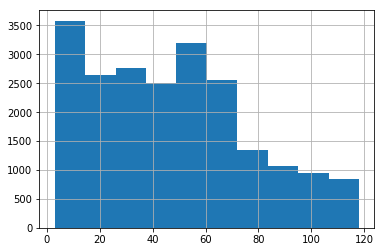

In [65]:
df.age.hist()

In [66]:
df.drop('yr_built', axis=1, inplace=True)

In [67]:
df.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,view,condition,grade,sqft_above,sqft_basement,lat,long,sqft_living15,sqft_lot15,distance,age
0,221900.0,3,1.00,1180,5650,1.0,0.0,3,7,1180,0,47.5112,-122.257,1340,5650,7.995528,63
1,538000.0,3,2.25,2570,7242,2.0,0.0,3,7,2170,400,47.7210,-122.319,1690,7639,7.689150,67
2,180000.0,2,1.00,770,10000,1.0,0.0,3,6,770,0,47.7379,-122.233,2720,8062,7.741887,85
3,604000.0,4,3.00,1960,5000,1.0,0.0,5,7,1050,910,47.5208,-122.393,1360,5000,10.403648,53
4,510000.0,3,2.00,1680,8080,1.0,0.0,3,8,1680,0,47.6168,-122.045,1800,7503,8.828511,31


### RENOVATIONS

In [68]:
df['renovated_living'] = df['sqft_living'] - df['sqft_living15']
df['renovated_lot'] = df['sqft_lot'] - df['sqft_lot15']

In [ ]:
df.renovated_living.corr(df.price)
df.renovated_lot.corr(df.price)

### CATEGORICAL VARIABLES

- View 
- Condition

To avoid dimensionality, a separate database with the following categorical variables was created. These will be run in an individual model to first test whether they add any value, and those that do will be add to the main model. 

We could also consider creating some binary variables - has the property been viewed or not? Is it in poor or good condition? Therefore, dummy vs binary will also be tested.

In [ ]:
cat_df = pd.DataFrame()

In [ ]:
cat_df['view'] = df.view.astype('category')

In [ ]:
cat_df['condition'] = df.condition.astype('category')

In [ ]:
df.loc[df['floors'] == 1.5, 'floors'] = 1
df.loc[df['floors'] == 2.5, 'floors'] = 2
df.loc[df['floors'] == 3.5, 'floors'] = 3
df.floors.astype(np.int64)

In [ ]:
cat_df['floors'] = df.floors.astype('category')

In [ ]:
cat_df['n_price'] = np.log(df['price'])

In [ ]:
cat_df = pd.get_dummies(cat_df);

In [ ]:
cat_df.head()
cat_df.rename(index=str, columns={"view0.0": "view0", "view1.0": "view1"}, inplace=True)
cat_df.head()

In [ ]:
cols_view = cat_df.columns[1:5]
cols_condition = cat_df.columns[6:10]
cols_floors = cat_df.columns[11:14]
 

cols = [cols_view, cols_condition , cols_floors]
for col in cols:
    sum_cols = "+".join(col)
    form = "price ~" + sum_cols
    model = smf.ols(formula= form, data= cat_df).fit()
    print(model.summary())

In [ ]:
cat_df.columns[11:14]

In [ ]:
#formula1 = "price ~ view_0.0 + view_1.0 + view_2.0 + view_3.0 + view_4.0"
#mo_cat1 = ols(formula= formula1, data=cat_df).fit()
#mo_cat1.summary()

In [ ]:
# drop from main dataset
to_drop = ['floors', 'condition']
df.drop(to_drop, axis=1, inplace=True)


## Identifying the general housing market

### Standardized Measures

In [69]:
#df.price = np.log(df['price'])
df.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,view,condition,grade,sqft_above,sqft_basement,lat,long,sqft_living15,sqft_lot15,distance,age,renovated_living,renovated_lot
0,221900.0,3,1.00,1180,5650,1.0,0.0,3,7,1180,0,47.5112,-122.257,1340,5650,7.995528,63,-160,0
1,538000.0,3,2.25,2570,7242,2.0,0.0,3,7,2170,400,47.7210,-122.319,1690,7639,7.689150,67,880,-397
2,180000.0,2,1.00,770,10000,1.0,0.0,3,6,770,0,47.7379,-122.233,2720,8062,7.741887,85,-1950,1938
3,604000.0,4,3.00,1960,5000,1.0,0.0,5,7,1050,910,47.5208,-122.393,1360,5000,10.403648,53,600,0
4,510000.0,3,2.00,1680,8080,1.0,0.0,3,8,1680,0,47.6168,-122.045,1800,7503,8.828511,31,-120,577


In [70]:
df_z = (df - df.mean())/df.std()
len(df_z)

21451

In [71]:
merged1 = df.merge(df_z, suffixes=('', '_z'), left_index=True, right_index=True)
merged1.columns

Index(['price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'view', 'condition', 'grade', 'sqft_above', 'sqft_basement', 'lat',
       'long', 'sqft_living15', 'sqft_lot15', 'distance', 'age',
       'renovated_living', 'renovated_lot', 'price_z', 'bedrooms_z',
       'bathrooms_z', 'sqft_living_z', 'sqft_lot_z', 'floors_z', 'view_z',
       'condition_z', 'grade_z', 'sqft_above_z', 'sqft_basement_z', 'lat_z',
       'long_z', 'sqft_living15_z', 'sqft_lot15_z', 'distance_z', 'age_z',
       'renovated_living_z', 'renovated_lot_z'],
      dtype='object')

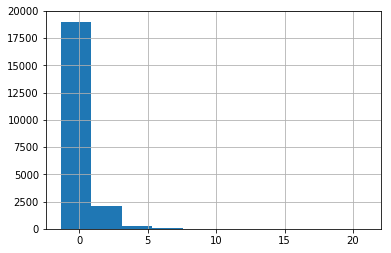

In [72]:
merged1.price_z.hist()

In [73]:
tail = len(merged1.loc[merged1['price_z'] > 3.29])  
(tail/len(merged1))*100
tail

323

1.5% (323 cases) fall outside of + 3.29 Std.This should be 0.13% for normally distributed data. Therefore the most extreme 1.3% (282 cases) will be removed as they arguably do not form part of the general housing market. Quite ideally, 282 cases correspond to 3.5 stds for normalized price. 

In [74]:
merged1.loc[merged1['price_z'] > 3.5] 

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,view,condition,grade,sqft_above,...,sqft_above_z,sqft_basement_z,lat_z,long_z,sqft_living15_z,sqft_lot15_z,distance_z,age_z,renovated_living_z,renovated_lot_z
21,2000000.0,3,2.75,3050,44867,1.0,4.0,3,9,2330,...,0.664864,1.005874,-0.206435,-0.138235,3.120833,0.280229,-0.702143,0.104113,-1.942330,0.771068
153,2250000.0,4,3.25,5180,19850,2.0,3.0,3,12,3540,...,2.137459,3.122068,0.012748,0.366263,1.727681,-0.107717,-0.859585,-1.189208,3.257408,0.269708
269,2900000.0,4,3.25,5050,20100,1.5,2.0,3,11,4750,...,3.610054,0.039786,0.511676,-0.067179,2.798208,0.270115,-1.652756,-0.372374,1.805533,-0.079795
282,2050000.0,5,3.00,3830,8480,2.0,1.0,5,9,2630,...,1.029970,2.109975,0.406411,-0.521937,1.566369,-0.188121,-1.336454,2.248303,1.164007,-0.049083
312,2380000.0,5,2.50,3650,9050,2.0,4.0,5,10,3370,...,1.930566,-0.006218,0.535469,-1.090384,1.317068,-0.267132,-0.742356,1.703747,1.147125,0.045623
518,2250000.0,4,2.25,4760,8036,2.5,0.0,5,9,3390,...,1.954906,2.501011,0.585938,-0.507725,1.419722,-0.123365,-1.327097,1.873921,2.902881,-0.125897
556,1950000.0,7,3.50,4640,15235,2.0,1.0,3,11,2860,...,1.309885,3.444097,0.045913,-0.124023,1.830335,0.293459,-1.091811,0.206217,2.227590,-0.270945
779,2250000.0,5,4.25,4860,9453,1.5,1.0,5,10,3100,...,1.601970,3.398093,0.428040,-0.514831,1.713017,-0.151437,-1.350879,2.248303,2.734058,-0.050056
814,2400000.0,4,4.25,4890,15188,2.0,2.0,3,11,3090,...,1.589800,3.490101,-0.000230,-0.095601,2.182289,0.128694,-1.019126,-0.950965,2.244472,-0.116378
1030,2450000.0,4,4.25,4250,6552,2.0,3.0,4,10,2870,...,1.322055,2.524013,0.104314,-0.493514,2.431590,-0.141029,-1.071257,-1.257278,0.877009,-0.160709


In [75]:
df1 = merged1.loc[merged1['price_z'] < 3.5] 

In [76]:
21597 - len(gen_df)

NameError: name 'gen_df' is not defined

In [77]:
df1.price.corr(df1.distance)

-0.44533628081042187

### Large lot sizes
 

The median lot size for a farm in Washington State is 871,200 sqft (https://www.reonomy.com/properties/farm/us/washington/1). The average residential lot size is 15,456 sqft. Our data indicate 169 cases larger than 200k sqft. This is roughly 0.08% of the dataset, yet these properties are 13x the average residential lot size. It is very likley that they do not form a part of the general housing market in King County. 

These will be removed from the dataset. 

In [78]:
df1 = df.loc[df['sqft_lot15'] < 200000]
df1 = df.loc[df['sqft_lot'] < 200000]

In [79]:
# In total 2% of the data set was removed.
21597 - len(df1)

403

## Transformations

In [ ]:
# drop z-scores based on previous data set
to_drop = ['price_z', 'bedrooms_z','bathrooms_z', 'sqft_living_z', 'sqft_lot_z', 'grade_z', 'sqft_above_z', 'sqft_basement_z', 'lat_z',
       'long_z', 'sqft_living15_z', 'sqft_lot15_z', 'distance_z', 'age_z']
#df2 = gen_df.drop(to_drop, axis=1)

In [ ]:
#df2.drop('condition', axis=1, inplace=True)

In [80]:
df2 = df
df2.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,view,condition,grade,sqft_above,sqft_basement,lat,long,sqft_living15,sqft_lot15,distance,age,renovated_living,renovated_lot
0,221900.0,3,1.00,1180,5650,1.0,0.0,3,7,1180,0,47.5112,-122.257,1340,5650,7.995528,63,-160,0
1,538000.0,3,2.25,2570,7242,2.0,0.0,3,7,2170,400,47.7210,-122.319,1690,7639,7.689150,67,880,-397
2,180000.0,2,1.00,770,10000,1.0,0.0,3,6,770,0,47.7379,-122.233,2720,8062,7.741887,85,-1950,1938
3,604000.0,4,3.00,1960,5000,1.0,0.0,5,7,1050,910,47.5208,-122.393,1360,5000,10.403648,53,600,0
4,510000.0,3,2.00,1680,8080,1.0,0.0,3,8,1680,0,47.6168,-122.045,1800,7503,8.828511,31,-120,577


In [ ]:
# Keep track of total number of subplots
k = len(df2.columns)
# n will be the number of chart columns. Change this to suit individual needs.  
# m will be the calculated number of required rows based on k and n
n = 2
m = (k - 1) // n + 1
#Create a figure and array of axes with required number of rows and columns.
fig, axes = plt.subplots(m, n, figsize=(10,14))
#Iterate through columns, tracking the column name and which number we are at i. Within each iteration, plot.

for i, (name, col) in enumerate(df2.iteritems()):
    r, c = i // n, i % n
    ax = axes[r, c]
    col.hist(ax=ax)
    ax2 = col.plot.kde(ax=ax, secondary_y=True, title=name)
    ax2.set_ylim(0)

fig.tight_layout()

In [ ]:
df2.renovated_lot.hist()
df2.renovated_lot.min()


In [ ]:
df2.renovated_living = df2.renovated_living
df2.renovated_living.min()

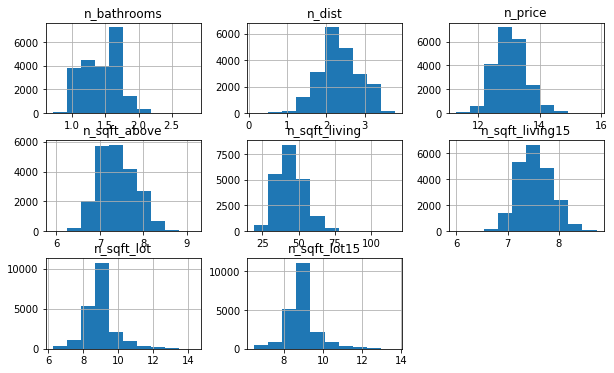

In [81]:
data_norm = pd.DataFrame([])
data_norm["n_price"] = np.log(df2["price"])
#data_norm['n_age'] = np.sqrt(df2['age'])
data_norm['n_sqft_living'] = np.sqrt(df2['sqft_living'])
data_norm['n_dist'] = np.log(df2['distance'] +1)
data_norm['n_sqft_lot15'] = np.log(df2['sqft_lot15'] +1)
data_norm['n_sqft_lot'] = np.log(df2['sqft_lot'] + 1)
data_norm['n_bathrooms'] = np.sqrt(df2['bathrooms'])
data_norm['n_sqft_above'] = np.log(df2['sqft_above'])
data_norm['n_sqft_living15'] = np.log(df2['sqft_living15'])
#data_norm['n_renovated_living'] = np.log(df2['renovated_living']+2311)
#data_norm['n_renoved_lot'] = np.sqrt(df2['renovated_lot'] + 326880)
data_norm.hist(figsize  = [10,6]);

#fig.tight_layout()

In [82]:
df3 = data_norm.merge(df, left_index=True, right_index=True)

In [83]:
to_drop = ['price','bathrooms', 'sqft_living', 'sqft_lot', 'sqft_above','sqft_living15', 'sqft_lot15', 'distance', 
           'age', 'renovated_living', 'renovated_lot']
df3.drop(to_drop, axis=1, inplace=True)

In [84]:
df3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21451 entries, 0 to 21596
Data columns (total 16 columns):
n_price            21451 non-null float64
n_sqft_living      21451 non-null float64
n_dist             21451 non-null float64
n_sqft_lot15       21451 non-null float64
n_sqft_lot         21451 non-null float64
n_bathrooms        21451 non-null float64
n_sqft_above       21451 non-null float64
n_sqft_living15    21451 non-null float64
bedrooms           21451 non-null int64
floors             21451 non-null float64
view               21451 non-null float64
condition          21451 non-null int64
grade              21451 non-null int64
sqft_basement      21451 non-null int32
lat                21451 non-null float64
long               21451 non-null float64
dtypes: float64(12), int32(1), int64(3)
memory usage: 3.3 MB


In [85]:
#standardize data set
df_z=(df3-df3.mean())/df3.std()
df_z.head()

,n_price,n_sqft_living,n_dist,n_sqft_lot15,n_sqft_lot,n_bathrooms,n_sqft_above,n_sqft_living15,bedrooms,floors,view,condition,grade,sqft_basement,lat,long
0,-1.412146,-1.076544,-0.281427,-0.389706,-0.383176,-1.603132,-0.751134,-1.032360,-0.412078,-0.914088,-0.295605,-0.629327,-0.558350,-0.650277,-0.353518,-0.308769
1,0.299156,0.651916,-0.348216,-0.017655,-0.107517,0.267860,0.679785,-0.321480,-0.412078,0.939405,-0.295605,-0.629327,-0.558350,0.269807,1.159129,-0.749316
2,-1.816518,-1.774764,-0.336553,0.048829,0.250822,-1.603132,-1.753789,1.136385,-1.519923,-0.914088,-0.295605,-0.629327,-1.417483,-0.650277,1.280977,-0.138235
3,0.522753,-0.027376,0.175756,-0.540462,-0.518887,1.136191,-1.025297,-0.986976,0.695766,-0.914088,-0.295605,2.448577,-0.558350,1.442914,-0.284302,-1.275130
4,0.195879,-0.374684,-0.110740,-0.039814,0.014073,-0.053151,0.078649,-0.128310,-0.412078,-0.914088,-0.295605,-0.629327,0.300783,-0.650277,0.407853,1.197617


## Correlations and Multicolinearity

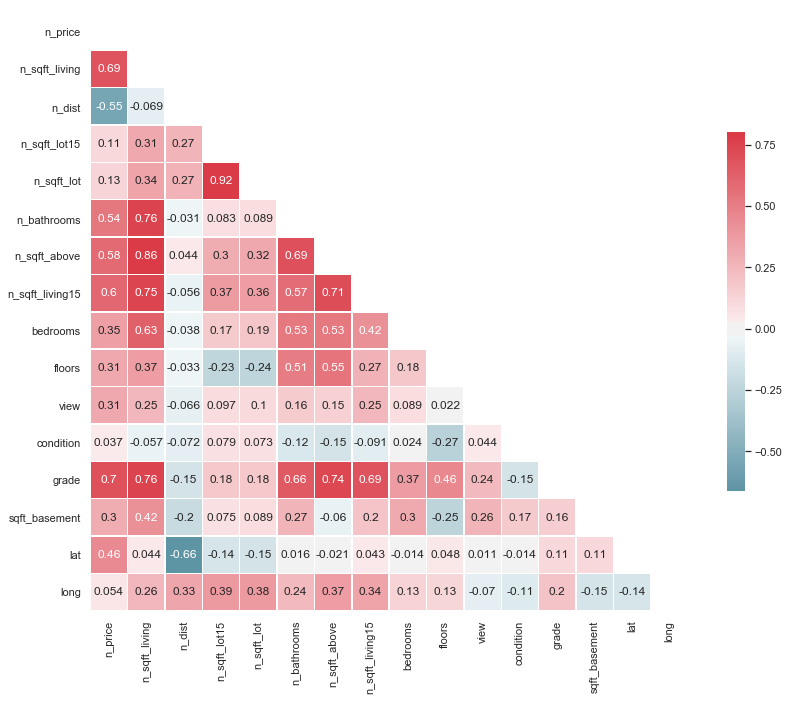

In [86]:
# Set the style of the visualization
sns.set(style="white")

# Create a covariance matrix
corr = df_z.corr()

# Generate a mask the size of our covariance matrix
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(14,11))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220,10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.8, center=0, square=True, linewidths=.4, annot=True, cbar_kws={'shrink':0.6});

High intercorrelations were seen especially between those variables related to size, as there is a large overlap with regards to what is being measured. Features related to living size were modeling to establish which to retain for the final model. Sqft_living has the highest correlation with price, and has an R-square of 0.48. 

Adding sqft_living15, bedrooms, bathrooms and sqft_above result in an R-square of 0.51. 

In [90]:
x = df_z.drop('n_price', axis=1)
y = df_z.n_price

# For each X, calculate VIF and save in dataframe
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(x.values, i) for i in range(x.shape[1])]
vif["features"] = x.columns
vif.round(1)

,VIF Factor,features
0,35.4,n_sqft_living
1,2.2,n_dist
2,6.7,n_sqft_lot15
3,7.0,n_sqft_lot
4,3.0,n_bathrooms
5,28.2,n_sqft_above
6,2.8,n_sqft_living15
7,1.8,bedrooms
8,2.4,floors
9,1.2,view


In [91]:
model = forward_selected(df_z, 'n_price')

print(model.model.formula)
# sl ~ rk + yr + 1

print(model.rsquared_adj)

n_price ~ grade + n_dist + n_sqft_living + lat + view + condition + n_sqft_living15 + sqft_basement + bedrooms + n_sqft_lot + floors + n_bathrooms + n_sqft_lot15 + long + 1
0.8105130685076944


In [ ]:
formula0 = "n_price ~ n_sqft_living" 
model0 = ols(formula= formula0, data=df_z).fit()
model0.summary()

In [ ]:
formula1 = "n_price ~ n_sqft_living + n_sqft_living15" 
model1 = ols(formula= formula1, data=df_z).fit()
model1.summary()

In [ ]:
formula2 = "n_price ~ n_sqft_living + n_sqft_living15+ n_bathrooms+bedrooms+n_sqft_above" 
model2 = ols(formula= formula2, data=df_z).fit()
model2.summary()

In [ ]:
final = df_z.drop(['long', 'n_sqft_lot', 'n_age', 'n_bathrooms', 'bedrooms', 'n_sqft_above'], axis=1)


In [ ]:
y = final['n_price']
x = final.drop('n_price', axis=1)
x.head();

# For each X, calculate VIF and save in dataframe
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(x.values, i) for i in range(x.shape[1])]
vif["features"] = x.columns
vif.round(1)

## Forward Selection and Verification: 1

In [87]:
import statsmodels.formula.api as smf

In [88]:
def forward_selected(data, response):
    """Linear model designed by forward selection.

    Parameters:
    -----------
    data : pandas DataFrame with all possible predictors and response

    response: string, name of response column in data

    Returns:
    --------
    model: an "optimal" fitted statsmodels linear model
           with an intercept
           selected by forward selection
           evaluated by adjusted R-squared
    """
    remaining = set(data.columns)
    remaining.remove(response)
    selected = []
    current_score, best_new_score = 0.0, 0.0
    while remaining and current_score == best_new_score:
        scores_with_candidates = []
        for candidate in remaining:
            formula = "{} ~ {} + 1".format(response,
                                           ' + '.join(selected + [candidate]))
            score = smf.ols(formula, data).fit().rsquared_adj
            scores_with_candidates.append((score, candidate))
        scores_with_candidates.sort()
        best_new_score, best_candidate = scores_with_candidates.pop()
        if current_score < best_new_score:
            remaining.remove(best_candidate)
            selected.append(best_candidate)
            current_score = best_new_score
    formula = "{} ~ {} + 1".format(response,
                                   ' + '.join(selected))
    model = smf.ols(formula, data).fit()
    return model

In [ ]:
model = forward_selected(final, 'n_price')

print(model.model.formula)
# sl ~ rk + yr + 1

print(model.rsquared_adj)

In [ ]:
linreg = LinearRegression()
r_list = []
adj_r_list = []
list_n = list(range(1,9))
for n in list_n: 
    select_n = RFE(linreg, n_features_to_select = n)
    select_n = select_n.fit(x, np.ravel(y))
    selected_columns = x.columns[select_n.support_ ]
    linreg.fit(x[selected_columns],y)
    yhat = linreg.predict(x[selected_columns])
    SS_Residual = np.sum((y-yhat)**2)
    SS_Total = np.sum((y-np.mean(y))**2)
    r_squared = 1 - (float(SS_Residual))/SS_Total
    print('Features: ' + str(n))
    print('R-squared: ' + str(r_squared))
    adjusted_r_squared = 1 - (1-r_squared)*(len(y)-1)/(len(y)-x.shape[1]-1)
    print('Adjusted R- sqaured: ' + str(adjusted_r_squared))
    print('------------------------------')
r_list.append(r_squared)
adj_r_list.append(adjusted_r_squared)

In [ ]:
print(list(range(1,11)))

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state=3)

MSE_test = []
MSE_train = []
list_n = list(range(1,11))
for n in list_n: 
    select_n = RFE(linreg, n_features_to_select = n)
    select_n = select_n.fit(x_train, np.ravel(y_train))
    selected_columns = x.columns[select_n.support_ ]
    linreg.fit(x_train[selected_columns],y_train)
    yhat_train = linreg.predict(x_train[selected_columns])
    yhat_test = linreg.predict(x_test[selected_columns])
    mse_train = np.sum((y_train-yhat_train)**2)/len(y_train)
    mse_test =np.sum((y_test-yhat_test)**2)/len(y_test)
    print('mse train: ' + str(mse_train))
    print('mse test: '+ str(mse_test))
    print('---------------------')
MSE_test.append(mse_test)
MSE_train.append(mse_train)

In [ ]:
select_5 = RFE(linreg, n_features_to_select = 5)
select_5 = select_n.fit(x, np.ravel(y))
selected_columns = x.columns[select_n.support_]

cv_10_results = cross_val_score(linreg, x[selected_columns], y, cv=10)

cv_10_results

In [ ]:
# Set the style of the visualization
sns.set(style="white")

# Create a covariance matrix
corr = final.corr()

# Generate a mask the size of our covariance matrix
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(14,11))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220,10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.9, center=0, square=True, linewidths=.4, annot=True, cbar_kws={'shrink':0.6});

- Model 1:   price ~ grade                                             = 49.1% 
- Model 2.1: price ~ grade + distance                                  = 54.0% (R-square change: 0.049)
- Model 2.2: price ~ sqft_living + distance + sqft_living              = 52.3% (R-square change: 0.023)
- Model 3:   price ~ sqft_living + distance + sqft_living + view       = 61.2% (R-square change: 0.121)
- Model 4:   price ~ sqft_living + distance + sqft_living + view + lat = 68.9% (R-square change: 0.077)

In [ ]:
formula = "n_price ~ grade + n_dist + n_sqft_living + view + lat" 
model = ols(formula= formula, data=final).fit()
model.summary()

In [ ]:
linreg = LinearRegression()
selector = RFE(linreg, n_features_to_select = 5)
selector = selector.fit(x, y)

selector.support_ 

selected_columns = x.columns[selector.support_ ]
linreg.fit(x[selected_columns],y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

yhat = linreg.predict(x[selected_columns])

SS_Residual = np.sum((y-yhat)**2)
SS_Total = np.sum((y-np.mean(y))**2)
r_squared = 1 - (float(SS_Residual))/SS_Total
adjusted_r_squared = 1 - (1-r_squared)*(len(y)-1)/(len(y)-x.shape[1]-1)

print(SS_Residual)
print(SS_Total)
print(r_squared)
print(adjusted_r_squared)

In [ ]:
warnings.filterwarnings('ignore')
residuals = y - yhat
#residuals.hist()
sns.distplot(residuals);

In [ ]:
fig, ax = plt.subplots(figsize=(12,8))
fig = sm.graphics.influence_plot(model, ax=ax, criterion="cooks")

In [ ]:
m = model
infl = m.get_influence()
sm_fr = infl.summary_frame()
sm_fr.head()